In [1]:
import os
import glob
import hydromt
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
import pandas as pd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
from matplotlib.ticker import FormatStrFormatter
import scipy

In [2]:
''' 
Script:
Author: L Grimley
Last Updated: 8/20/24

Description: 

Inputs:
- outputs from SFINCS_zsmax2netcdf.ipynb

Outputs:
- outputs figure
- outputs depth csv f'max_depth_stats_future_{type}.csv'

'''

" \nScript:\nAuthor: L Grimley\nLast Updated: 8/20/24\n\nDescription: \n\nInputs:\n- outputs from SFINCS_zsmax2netcdf.ipynb\n\nOutputs:\n- outputs figure\n- outputs depth csv f'max_depth_stats_future_{type}.csv'\n\n"

In [3]:
work_dir = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3'
os.chdir(os.path.join(work_dir, 'ensemble_mean_mask'))

pres_zsmax_all = xr.open_dataarray(os.path.join(work_dir, 'pgw_zsmax.nc'))
fut_ensmean_zsmax = xr.open_dataarray(os.path.join(work_dir, 'ensemble_mean', 'fut_ensemble_zsmax_mean.nc'))

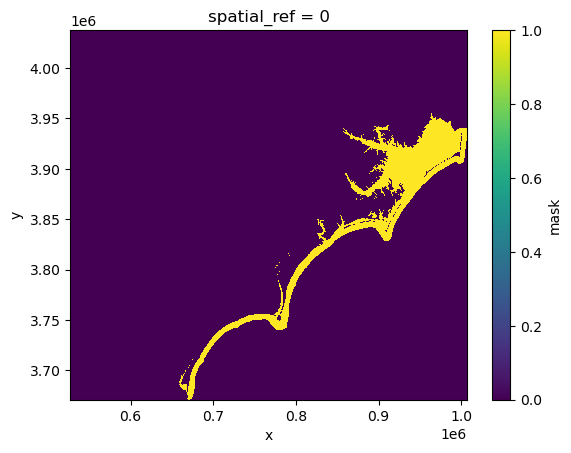

In [4]:
# Load a SFINCS model and get elevation
yml_base = r'Z:\Data-Expansion\users\lelise\data\data_catalog_BASE_Carolinas.yml'
root = r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\01_AGU2023\future_florence\future_florence_ensmean'
mod = SfincsModel(root=root, mode='r', data_libs=[yml_base])
dep = mod.grid['dep']

# Load coastal waterbody shapefile
coastal_wb = mod.data_catalog.get_geodataframe('carolinas_coastal_wb')
coastal_wb = coastal_wb.to_crs(mod.crs)
coastal_wb_clip = coastal_wb.clip(mod.region)

# Create water body mask
coastal_wb_clip['mask'] = 1.0
mask1 = dep.raster.rasterize(coastal_wb_clip, "mask", nodata=0.0, all_touched=False)
mask1.plot()

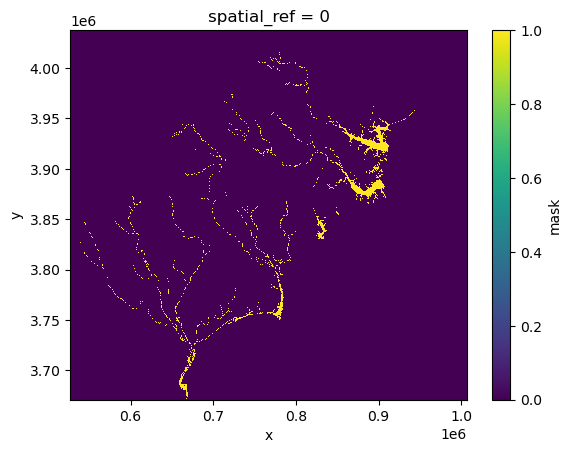

In [5]:
carolinas_nhd_area_rivers = mod.data_catalog.get_geodataframe('carolinas_nhd_area_rivers', geom=mod.region)
carolinas_nhd_area_rivers = carolinas_nhd_area_rivers.to_crs(mod.crs)
carolinas_nhd_area_rivers['mask'] = 1.0
mask2 = dep.raster.rasterize(carolinas_nhd_area_rivers, "mask", nodata=0.0, all_touched=True)
mask2.plot()

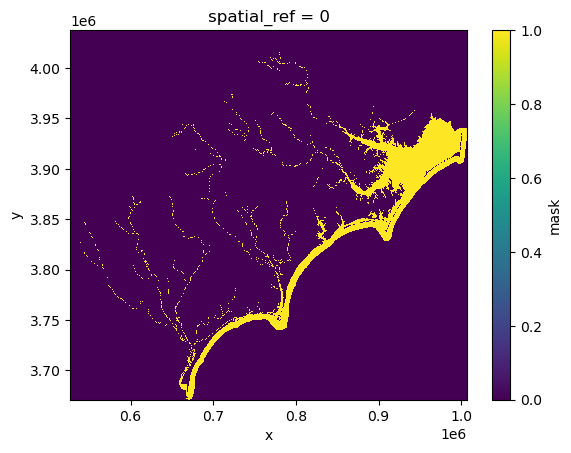

In [6]:
mask = (mask1 + mask2).compute()
mask = xr.where(cond = mask > 0.0, x= 1.0,y=0.0)
mask.plot()
#mask.raster.to_raster(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_2\water_mask_notAllTouched.tif', nodata=-9999.0)

In [7]:
# Loop through and get the max depth for plotting
ds_plot1 = []
storms = ['flor', 'floy', 'matt']
for storm in storms:
    pres_zsmax = pres_zsmax_all.sel(run=f'{storm}_pres_compound')
    pres_hmax = (pres_zsmax - dep).compute()
    pres_hmax = pres_hmax.where(pres_hmax > 0.05)
    pres_hmax.name = f'{storm}_pres_compound_hmax'

    #fut_zsmax = fut_ensmean_zsmax.sel(run=f'{storm}_fut_compound_mean')
    fut_hmax = (fut_zsmax - dep).compute()
    fut_hmax = fut_hmax.where(fut_hmax > 0.05)
    fut_hmax.name = f'{storm}_fut_compound_hmax'

    dep_diff = (fut_hmax.fillna(0) - pres_hmax.fillna(0)).compute()
    dep_diff.name = f'{storm}_fut_minus_pres_compound_hmax'
    ds_plot1 = ds_plot1 + [pres_hmax, fut_hmax, dep_diff]

In [8]:
# Loop through and mask the data
ds_plot = []
for ds in ds_plot1:
    dd = ds.where(mask == 0.0)
    ds_plot.append(dd)

In [9]:
col_title = ['Present', 'Future', 'Depth Difference']
row_titles = ['Florence', 'Floyd', 'Matthew']
nrow = 3
ncol = 3

# Plotting info
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})
mpl.rcParams["figure.autolayout"] = True
n_subplots = nrow * ncol
first_in_row = np.arange(0, n_subplots, ncol)
last_in_row = np.arange(ncol - 1, n_subplots, ncol)
first_row = np.arange(0, ncol)
last_row = np.arange(first_in_row[-1], n_subplots, 1)

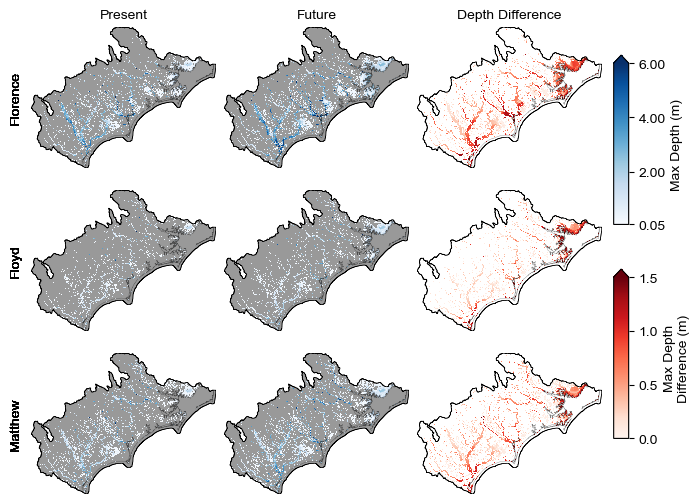

In [20]:
fig, axes = plt.subplots(
    nrows=nrow, ncols=ncol,
    figsize=(6, 5),
    subplot_kw={'projection': utm},
    tight_layout=True,
    layout='constrained')
axes = axes.flatten()
counter = 0
for ax in axes:
    if counter in last_in_row:
        ckwargs = dict(cmap='Reds', vmin=0, vmax=1.5)
        cs2 = ds_plot[counter].where(ds_plot[counter] > 0).plot(ax=ax,
                                                                add_colorbar=False,
                                                                **ckwargs,
                                                                zorder=1)
        coastal_wb_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, zorder=1, alpha=0.5)
    else:
        ckwargs = dict(cmap='Blues', vmin=0.05, vmax=6)
        cs = ds_plot[counter].plot(ax=ax,
                                   add_colorbar=False,
                                   **ckwargs,
                                   zorder=1)
        mod.region.plot(ax=ax, color='grey', edgecolor='none', zorder=0, alpha=0.8)
        coastal_wb_clip.plot(ax=ax, color='none', edgecolor='black', linewidth=0.25, zorder=1, alpha=0.5)


    mod.region.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=2, alpha=1)

    ax.set_title('')
    ax.set_axis_off()
    if counter in first_row:
        ax.set_title(col_title[counter], loc='center', fontsize=10)
    for i in range(len(first_in_row)):
        axes[first_in_row[i]].text(-0.05, 0.5, row_titles[i],
                                   horizontalalignment='right',
                                   verticalalignment='center',
                                   rotation='vertical',
                                   transform=axes[first_in_row[i]].transAxes)
    counter += 1

label = 'Max Depth (m)'
ax = axes[2]
pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 + 0.02, pos0.y0 + pos0.height * -0.4, 0.025, pos0.height * 1.2])
cbar2 = fig.colorbar(cs,
                     cax=cax,
                     orientation='vertical',
                     label=label,
                     ticks=[0.05, 2, 4, 6, 8],
                     extend='max'
                     )

label = 'Max Depth\nDifference (m)'
ax = axes[5]
pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 + 0.02, pos0.y0 + pos0.height * -0.8, 0.025, pos0.height * 1.2])
cbar2 = fig.colorbar(cs2,
                     cax=cax,
                     orientation='vertical',
                     label=label,
                     ticks=[0, 0.5, 1, 1.5],
                     extend='max')

plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.margins(x=0, y=0)
plt.savefig('floodmap_pres_fut_ensmean_diff.png',bbox_inches='tight', dpi=255)
#plt.close()

In [11]:
df_dep_stats = pd.DataFrame()
for ds in ds_plot:
    ds = xr.where(ds == 0, np.nan, ds)
    df = ds.to_dataframe().dropna(how='any', axis=0)
    df = df.drop(columns='spatial_ref')
    df_stats = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    df_dep_stats = pd.concat([df_dep_stats, df_stats], ignore_index=False, axis=1)
df_dep_stats = df_dep_stats.round(3)
print(os.getcwd())
df_dep_stats.to_csv('max_depth_stats_future.csv')
print(df_dep_stats)

Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter2_PGW\sfincs\03_OBS\analysis_3\ensemble_mean_mask
       flor_pres_compound_hmax  flor_fut_compound_hmax  \
count               328934.000              407426.000   
mean                     1.237                   1.508   
std                      1.268                   1.425   
min                      0.050                   0.050   
5%                       0.085                   0.093   
25%                      0.277                   0.356   
50%                      0.815                   1.142   
75%                      1.797                   2.204   
95%                      3.789                   4.311   
max                     42.404                  42.966   

       flor_fut_minus_pres_compound_hmax  floy_pres_compound_hmax  \
count                         407362.000               182132.000   
mean                               0.509                    0.652   
std                                0.360

In [12]:
dep_stats_all = []

for ds in ds_plot:
    if 'minus' in ds.name:
        ds = xr.where(ds <= 0, np.nan, ds)  # get rid of points that are less than or equal to zero for this calculation
        ds = ds.data
        dep_stats_all.append(ds)
    else:
        print(ds.name)

array = np.concatenate(dep_stats_all, axis=0)
array = array[~np.isnan(array)]


print('cells: ', len(array))
print('mean: ',np.mean(array))
print('std: ', np.std(array))
print('median: ', np.median(array))
print('95%: ', np.percentile(array, 95))

flor_pres_compound_hmax
flor_fut_compound_hmax
floy_pres_compound_hmax
floy_fut_compound_hmax
matt_pres_compound_hmax
matt_fut_compound_hmax
cells:  1053494
mean:  0.44605595
std:  0.35154334
median:  0.3504343
95%:  1.0981063842773438


In [16]:
# Wilcoxon rank-sum statistic for two independent samples that are not normally distributed.
# A negative statistic (U) indicates that the group1 (present) tends to have lower values compared to the group2 (future)
# It also suggests that the null hypothesis (no difference between the groups) is likely not true
# If p-value is less than 0.05, we reject the null hypothesis

# Group1
ds = ds_plot[0]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
p = df.drop(columns='spatial_ref')

# Group2
ds = ds_plot[1]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
f = df.drop(columns='spatial_ref')

storm = 'flor'
group1 = p[f'{storm}_pres_compound_hmax'].values.astype(float)
group2 = f[f'{storm}_fut_compound_hmax'].values.astype(float)
m1 = np.median(group1)
m2 = np.median(group2)
print(f"Median depth Pres and Fut is {np.round(m1,2)} and {np.round(m2, 2)}")

print(f"Mean depth Pres and Fut is {np.round(np.mean(group1),2)} and {np.round(np.mean(group2), 2)}")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='two-sided')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; two-sided.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='less')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; less.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='greater')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}; This test says that Present is greater than Future. P = 1 says reject this hypothesis.")

Median depth Pres and Fut is 0.81 and 1.14
Mean depth Pres and Fut is 1.24 and 1.51
Mann–Whitney U = -85.05, nPres = 328934; nFut = 407426, P = 0.0; two-sided.
Mann–Whitney U = -85.05, nPres = 328934; nFut = 407426, P = 0.0; less.
Mann–Whitney U = -85.05, nPres = 328934; nFut = 407426; This test says that Present is greater than Future. P = 1 says reject this hypothesis.


In [17]:
# Wilcoxon rank-sum statistic for the two samples
ds = ds_plot[3]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
p = df.drop(columns='spatial_ref')

ds = ds_plot[4]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
f = df.drop(columns='spatial_ref')

storm = 'floy'
group1 = p[f'{storm}_pres_compound_hmax'].values.astype(float)
group2 = f[f'{storm}_fut_compound_hmax'].values.astype(float)
m1 = np.median(group1)
m2 = np.median(group2)
print(f"Median depth Pres and Fut is {np.round(m1,2)} and {np.round(m2, 2)}")
print(f"Mean depth Pres and Fut is {np.round(np.mean(group1),2)} and {np.round(np.mean(group2), 2)}")
statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='two-sided')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; two-sided.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='less')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; less.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='greater')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; This test says that Present is greater than Future. P = 1 says reject this hypothesis.")

Median depth Pres and Fut is 0.42 and 0.68
Mean depth Pres and Fut is 0.65 and 0.88
Mann–Whitney U = -106.16, nPres = 182132; nFut = 253028, P = 0.0; two-sided.
Mann–Whitney U = -106.16, nPres = 182132; nFut = 253028, P = 0.0; less.
Mann–Whitney U = -106.16, nPres = 182132; nFut = 253028, P = 1.0; This test says that Present is greater than Future. P = 1 says reject this hypothesis.


In [18]:
# Wilcoxon rank-sum statistic for the two samples
ds = ds_plot[6]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
p = df.drop(columns='spatial_ref')

ds = ds_plot[7]
ds = xr.where(ds == 0, np.nan, ds)
df = ds.to_dataframe().dropna(how='any', axis=0)
f = df.drop(columns='spatial_ref')

storm = 'matt'
group1 = p[f'{storm}_pres_compound_hmax'].values.astype(float)
group2 = f[f'{storm}_fut_compound_hmax'].values.astype(float)
m1 = np.median(group1)
m2 = np.median(group2)
print(f"Median depth Pres and Fut is {np.round(m1,2)} and {np.round(m2, 2)}")
print(f"Mean depth Pres and Fut is {np.round(np.mean(group1),2)} and {np.round(np.mean(group2), 2)}")
statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='two-sided')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; two-sided.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='less')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; less.")

statistic, p_value = scipy.stats.ranksums(group1, group2, alternative='greater')
print(f"Mann–Whitney U = {np.round(statistic, 2)}, nPres = {len(group1)}; nFut = {len(group2)}, P = {p_value}; This test says that Present is greater than Future. P = 1 says reject this hypothesis.")

Median depth Pres and Fut is 0.57 and 0.81
Mean depth Pres and Fut is 0.92 and 1.13
Mann–Whitney U = -79.68, nPres = 308883; nFut = 393337, P = 0.0; two-sided.
Mann–Whitney U = -79.68, nPres = 308883; nFut = 393337, P = 0.0; less.
Mann–Whitney U = -79.68, nPres = 308883; nFut = 393337, P = 1.0; This test says that Present is greater than Future. P = 1 says reject this hypothesis.
